In [95]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator

import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글폰트 설정
mpl.rc('font',family='Malgun Gothic')

# color pallette
cnf, dth, rec, act = '#393e46', '#ff2e63', '#21bf73', '#fe9801' 
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

# 기본 폰트 설정
layout_font = {'font':dict(size=12,color='#60606e',family='Malgun Gothic' )}

데이터셋 불러오기

In [96]:
df18 = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv')
df19 = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv')
df20 = pd.read_csv('서울시우리마을가게상권분석서비스(상권-추정매출)_2020.csv')

df1 = pd.read_csv('행정동코드.csv')
df2= pd.read_csv('상권영역.csv',index_col=False)


In [97]:
code = df1[df1["CT_NM(시군구명)"]=='용산구']
code.rename(columns={'H_SDNG_CD(통계청행정동코드)':"통계청행정동코드"},inplace=True)
code.rename(columns={'H_DNG_CD(행자부행정동코드)':"행정동코드"},inplace=True)
code.rename(columns={"DO_NM(시도명)":"시도명"},inplace=True)
code.rename(columns={"CT_NM(시군구명)":"시군구명"},inplace=True)
code.rename(columns={"H_DNG_NM(행정동명)":"행정동명"},inplace=True)

df2 = pd.merge(df2,code, how='left', left_on='ADSTRD_CD', right_on='행정동코드')#code.iloc[:,1:]
df2 = df2.dropna()

df18 = pd.merge(df18,df2, how='left', left_on='상권_코드', right_on='TRDAR_CD')
df18 = df18.dropna()
df19 = pd.merge(df19,df2, how='left', left_on='상권_코드', right_on='TRDAR_CD')
df19 = df19.dropna()
df20 = pd.merge(df20,df2, how='left', left_on='상권_코드', right_on='TRDAR_CD')
df20 = df20.dropna()

In [4]:
## 행정동 기준으로 

# df_18 = pd.DataFrame(df18.groupby(['기준_분기_코드','행정동명'], as_index=False)['분기당_매출_금액'].mean())
# df_19 = pd.DataFrame(df19.groupby(['기준_분기_코드','행정동명'], as_index=False)['분기당_매출_금액'].mean())
# df_20 = pd.DataFrame(df20.groupby(['기준_분기_코드','행정동명'], as_index=False)['분기당_매출_금액'].mean())

df_18 = df18.query('(행정동명 =="이태원1동")|(행정동명 =="이태원2동")')
df_19 = df19.query('(행정동명 =="이태원1동")|(행정동명 =="이태원2동")')
df_20 = df20.query('(행정동명 =="이태원1동")|(행정동명 =="이태원2동")')

In [5]:
yd = pd.read_csv('상권별 유동인구.csv')

In [6]:
tmp1 = df_19.query('행정동명=="이태원1동"')['상권_코드'].unique()
tmp2 = df_19.query('행정동명=="이태원2동"')['상권_코드'].unique()

def classification(x):
    if x['상권 코드'] in tmp1:
        return '이태원1동'
    elif x['상권 코드'] in tmp2:
        return '이태원2동'

yd['행정동명'] = yd.apply(classification,axis=1)

yd['생활인구(평균)'] = yd['생활인구(평균)'].str.replace(',','')
yd['생활인구(평균)'] = yd['생활인구(평균)'].astype('int64') 

점포수

In [7]:
df_19_sum = pd.DataFrame(df_19.groupby(['기준_분기_코드','상권_코드_명','행정동명'], as_index=False)['점포수'].sum())
df_20_sum = pd.DataFrame(df_20.groupby(['기준_분기_코드','상권_코드_명','행정동명'], as_index=False)['점포수'].sum())
jumpo = pd.concat([df_19_sum,df_20_sum])

매출금액평균

In [8]:
df_18 = pd.DataFrame(df_18.groupby(['기준_분기_코드','상권_코드_명','행정동명'], as_index=False)['분기당_매출_금액'].mean())
df_19 = pd.DataFrame(df_19.groupby(['기준_분기_코드','상권_코드_명','행정동명'], as_index=False)['분기당_매출_금액'].mean())
df_20 = pd.DataFrame(df_20.groupby(['기준_분기_코드','상권_코드_명','행정동명'], as_index=False)['분기당_매출_금액'].mean())
# df.groupby(['시간대구분','행정동명'])['총생활인구수'].transform('mean')

In [9]:
df_18['분기당_매출_금액'] = df_18['분기당_매출_금액'].astype('int64')
df_19['분기당_매출_금액'] = df_19['분기당_매출_금액'].astype('int64')
df_20['분기당_매출_금액'] = df_20['분기당_매출_금액'].astype('int64')

df_19['전년도 분기 대비 매출증감액'] = df_19["분기당_매출_금액"].values - df_18["분기당_매출_금액"].values

df_19['전년도 분기 대비 매출증감율'] = (df_19['전년도 분기 대비 매출증감액'].values / df_18["분기당_매출_금액"].values) * 100

df_20['전년도 분기 대비 매출증감액'] = df_20["분기당_매출_금액"].values - df_19["분기당_매출_금액"].values
df_20['전년도 분기 대비 매출증감율'] = (df_20['전년도 분기 대비 매출증감액'].values / df_19["분기당_매출_금액"].values) * 100

def year_add(x):
    return '2019년 '+str(x)+'분기'

df_19['기준_분기_코드'] = df_19['기준_분기_코드'].apply(year_add)

def year_add(x):
    return '2020년 '+str(x)+'분기'

df_20['기준_분기_코드'] = df_20['기준_분기_코드'].apply(year_add)

In [10]:
result = pd.concat([df_19,df_20])

In [11]:
result['전년도 분기 대비 매출증감율'] = result['전년도 분기 대비 매출증감율'].round(1)

In [12]:
result.sort_values(by=['기준_분기_코드','상권_코드_명'],inplace=True)

In [13]:
yd.sort_values(by=['분기','상권 코드 명'],inplace=True)

In [14]:
yd.reset_index(drop=True,inplace=True)

In [15]:
result.reset_index(drop=True,inplace=True)

In [16]:
result['생활인구(평균)'] = yd['생활인구(평균)']

In [17]:
jumpo.sort_values(by=['기준_분기_코드','상권_코드_명'],inplace=True)
jumpo.reset_index(drop=True,inplace=True)

In [18]:
result['점포수'] = jumpo['점포수']

In [19]:
result['생활인구(총합)'] = result['생활인구(평균)'].values * 2 

In [20]:
def social_dist_dummy(x):
    if x['기준_분기_코드'] == "2019년 1분기": return 0
    elif x['기준_분기_코드'] == "2019년 2분기": return 0
    elif x['기준_분기_코드'] == "2019년 3분기": return 0
    elif x['기준_분기_코드'] == "2019년 4분기": return 0
    elif x['기준_분기_코드'] == "2020년 1분기": return 0
    elif x['기준_분기_코드'] == "2020년 2분기": return 0
    elif x['기준_분기_코드'] == "2020년 3분기": return 1
    elif x['기준_분기_코드'] == "2020년 4분기": return 1

result['사회적거리두기_2단계'] = result.apply(social_dist_dummy,axis=1)


In [21]:
def sub_money_dummy(x):
    if x['기준_분기_코드'] == "2019년 1분기": return 0
    elif x['기준_분기_코드'] == "2019년 2분기": return 0
    elif x['기준_분기_코드'] == "2019년 3분기": return 0
    elif x['기준_분기_코드'] == "2019년 4분기": return 0
    elif x['기준_분기_코드'] == "2020년 1분기": return 0
    elif x['기준_분기_코드'] == "2020년 2분기": return 1
    elif x['기준_분기_코드'] == "2020년 3분기": return 1
    elif x['기준_분기_코드'] == "2020년 4분기": return 0
    
result['지원금'] = result.apply(sub_money_dummy,axis=1)


In [22]:
result

기준_분기_코드      상권_코드_명   행정동명   분기당_매출_금액  전년도 분기 대비 매출증감액  \
0   2019년 1분기     녹사평대로26길  이태원1동   187140119         -4061331   
1   2019년 1분기     녹사평대로32길  이태원1동   447236944         56855806   
2   2019년 1분기    녹사평대로40나길  이태원2동   309916132          9908876   
3   2019년 1분기     녹사평대로46길  이태원2동   186163183       -109247490   
4   2019년 1분기  서울 용산구 이태원역  이태원1동  1354081547         39543919   
..        ...          ...    ...         ...              ...   
83  2020년 4분기     이태원 관광특구  이태원1동  1728825725       -878897237   
84  2020년 4분기      이태원로27길  이태원1동   912068550       -766164466   
85  2020년 4분기        이태원시장  이태원1동   472483963       -175667222   
86  2020년 4분기      이태원제일시장  이태원2동    77001673       -178350654   
87  2020년 4분기      회나무로13길  이태원2동   202582082        -18894395   

    전년도 분기 대비 매출증감율  생활인구(평균)  점포수  생활인구(총합)  사회적거리두기_2단계  지원금  
0              -2.1     39058   99     78116            0    0  
1              14.6     65437   94    130874            0    0  
2               3.3     51967  155    103934            0    0  
3             -37.0     43669  146     87338            0    0  
4               3.0     96608   95    193216            0    0  
..              ...       ...  ...       ...          ...  ...  
83            -33.7    248378  151    496756            1    0  
84            -45.7     42134    4     84268            1    0  
85            -27.1      4595    7      9190            1    0  
86            -69.8      8388  155     16776            1    0  
87             -8.5     55654  149    111308            1    0  

[88 rows x 11 columns]

In [23]:
result[pd.get_dummies(result['기준_분기_코드']).columns] = pd.get_dummies(result['기준_분기_코드']).values


In [24]:
# def year_dummy(x):
#     if '2019년' ==x['기준_분기_코드'].split()[0]  :
#         return 0
#     else:
#         return 1

# result['년(dummy)'] = result.apply(year_dummy,axis=1)


In [25]:
# def bungi1_dummy(x):
#     if x['기준_분기_코드'].split()[1] == '1분기': return 0
#     else : return 0
# def bungi2_dummy(x):
#     if x['기준_분기_코드'].split()[1] == '2분기': return 1
#     else : return 0
# def bungi3_dummy(x):
#     if x['기준_분기_코드'].split()[1] == '3분기': return 1
#     else : return 0
# def bungi4_dummy(x):
#     if x['기준_분기_코드'].split()[1] == '4분기': return 1
#     else : return 0

# result['1분기(dummy)'] = result.apply(bungi1_dummy,axis=1)
# result['2분기(dummy)'] = result.apply(bungi2_dummy,axis=1)
# result['3분기(dummy)'] = result.apply(bungi3_dummy,axis=1)
# result['4분기(dummy)'] = result.apply(bungi4_dummy,axis=1)


In [26]:
a = pd.read_csv('서울특별시 코로나19 자치구별 확진자 발생동향.csv',encoding='cp949')

In [27]:
a = a[['자치구 기준일','용산구 전체','용산구 추가']]

In [28]:
a.dropna(inplace=True)

In [29]:
a['년'] = pd.to_datetime(a['자치구 기준일']).dt.year

In [30]:
a['월'] = pd.to_datetime(a['자치구 기준일']).dt.month

In [31]:
a = a.query('년==2020')

In [32]:
a.to_csv('2020 용산구 확진자수 추이.csv',index=False)

In [33]:
b = pd.DataFrame(a.groupby(['월'], as_index=False)['용산구 추가'].sum())

In [34]:
def bungi(x):
#     print(x)
    if x in [2,3]:
        return 1
    elif x in [4,5,6]:
        return 2
    elif x in [7,8,9]:
        return 3
    else:
        return 4
b['분기'] = b['월'].apply(bungi)

In [35]:
b = pd.DataFrame(b.groupby(['분기'], as_index=False)['용산구 추가'].sum())

In [36]:
b

분기  용산구 추가
0   1    12.0
1   2    38.0
2   3    72.0
3   4   294.0

In [37]:
result

기준_분기_코드      상권_코드_명   행정동명   분기당_매출_금액  전년도 분기 대비 매출증감액  \
0   2019년 1분기     녹사평대로26길  이태원1동   187140119         -4061331   
1   2019년 1분기     녹사평대로32길  이태원1동   447236944         56855806   
2   2019년 1분기    녹사평대로40나길  이태원2동   309916132          9908876   
3   2019년 1분기     녹사평대로46길  이태원2동   186163183       -109247490   
4   2019년 1분기  서울 용산구 이태원역  이태원1동  1354081547         39543919   
..        ...          ...    ...         ...              ...   
83  2020년 4분기     이태원 관광특구  이태원1동  1728825725       -878897237   
84  2020년 4분기      이태원로27길  이태원1동   912068550       -766164466   
85  2020년 4분기        이태원시장  이태원1동   472483963       -175667222   
86  2020년 4분기      이태원제일시장  이태원2동    77001673       -178350654   
87  2020년 4분기      회나무로13길  이태원2동   202582082        -18894395   

    전년도 분기 대비 매출증감율  생활인구(평균)  점포수  생활인구(총합)  사회적거리두기_2단계  지원금  2019년 1분기  \
0              -2.1     39058   99     78116            0    0          1   
1              14.6     65437   94    130874            0    0          1   
2               3.3     51967  155    103934            0    0          1   
3             -37.0     43669  146     87338            0    0          1   
4               3.0     96608   95    193216            0    0          1   
..              ...       ...  ...       ...          ...  ...        ...   
83            -33.7    248378  151    496756            1    0          0   
84            -45.7     42134    4     84268            1    0          0   
85            -27.1      4595    7      9190            1    0          0   
86            -69.8      8388  155     16776            1    0          0   
87             -8.5     55654  149    111308            1    0          0   

    2019년 2분기  2019년 3분기  2019년 4분기  2020년 1분기  2020년 2분기  2020년 3분기  \
0           0          0          0          0          0          0   
1           0          0          0          0          0          0   
2           0          0          0          0          0          0   
3           0          0          0          0          0          0   
4           0          0          0          0          0          0   
..        ...        ...        ...        ...        ...        ...   
83          0          0          0          0          0          0   
84          0          0          0          0          0          0   
85          0          0          0          0          0          0   
86          0          0          0          0          0          0   
87          0          0          0          0          0          0   

    2020년 4분기  
0           0  
1           0  
2           0  
3           0  
4           0  
..        ...  
83          1  
84          1  
85          1  
86          1  
87          1  

[88 rows x 19 columns]

In [38]:
def c(x):
    if x['2019년 1분기'] == 1: return 0
    elif x['2019년 2분기'] == 1: return 0
    elif x['2019년 3분기'] == 1: return 0
    elif x['2019년 4분기'] == 1: return 0
    elif x['2020년 1분기'] == 1: return 12
    elif x['2020년 2분기'] == 1: return 38
    elif x['2020년 3분기'] == 1: return 72
    elif x['2020년 4분기'] == 1: return 294

result['확진자수'] = result.apply(c,axis=1)

선형회귀

In [39]:
result.columns

Index(['기준_분기_코드', '상권_코드_명', '행정동명', '분기당_매출_금액', '전년도 분기 대비 매출증감액',
       '전년도 분기 대비 매출증감율', '생활인구(평균)', '점포수', '생활인구(총합)', '사회적거리두기_2단계', '지원금',
       '2019년 1분기', '2019년 2분기', '2019년 3분기', '2019년 4분기', '2020년 1분기',
       '2020년 2분기', '2020년 3분기', '2020년 4분기', '확진자수'],
      dtype='object')

---

# 회귀분석

In [40]:
# def a(x):
#     if x['기준_분기_코드'] == '2019년 1분기': return 0
#     elif x['기준_분기_코드'] == '2019년 2분기': return 0
#     elif x['기준_분기_코드'] == '2019년 3분기': return 0
#     elif x['기준_분기_코드'] == '2019년 4분기': return 0
#     elif x['기준_분기_코드'] == '2020년 1분기': return 1
#     elif x['기준_분기_코드'] == '2020년 2분기': return 1
#     elif x['기준_분기_코드'] == '2020년 3분기': return 2
#     elif x['기준_분기_코드'] == '2020년 4분기': return 2

# result['사회적거리두기_2단계'] = result.apply(a,axis=1)

# so_dist = pd.get_dummies(result['사회적거리두기_2단계'],drop_first=True).rename(columns={1:"사회적거리두기 1단계",2:"사회적거리두기 2단계"})

# so_dist['생활인구(총합)'] = result['생활인구(총합)']

# so_dist

In [41]:
result1 = result[['기준_분기_코드','분기당_매출_금액', '전년도 분기 대비 매출증감액', '생활인구(총합)','확진자수']]

In [42]:
def asdf(x):
    if x['전년도 분기 대비 매출증감액'] < 0:
        return float('-'+str(np.log(abs(x['전년도 분기 대비 매출증감액']))))
    else:
        return np.log(x['전년도 분기 대비 매출증감액'])
        
result1['전년도 분기 대비 매출증감액'] = result1.apply(asdf ,axis=1)

In [43]:
result1['생활인구(총합)'] = np.log(result['생활인구(총합)'])
result1['분기당_매출_금액'] = np.log(result['분기당_매출_금액'].values / result['점포수'].values)
# result1['확진자수'] = np.log(result['확진자수'])

In [44]:
# 레이블 분리
data_money = result1[["분기당_매출_금액"]]
data_corona = result[['지원금']]
data = result1.drop("분기당_매출_금액", axis=1)

In [45]:
result1

기준_분기_코드  분기당_매출_금액  전년도 분기 대비 매출증감액   생활인구(총합)  확진자수
0   2019년 1분기  14.452248       -15.217021  11.265950     0
1   2019년 1분기  15.375304        17.856029  11.781990     0
2   2019년 1분기  14.508387        16.108941  11.551511     0
3   2019년 1분기  14.058528       -18.509126  11.377541     0
4   2019년 1분기  16.472512        17.492922  12.171564     0
..        ...        ...              ...        ...   ...
83  2020년 4분기  16.253428       -20.594179  13.115854   294
84  2020년 4분기  19.244931       -20.456907  11.341757   294
85  2020년 4분기  18.027604       -18.984102   9.125871   294
86  2020년 4분기  13.115913       -18.999262   9.727705   294
87  2020년 4분기  14.122709       -16.754376  11.620056   294

[88 rows x 5 columns]

In [46]:
# 범주형 특징(sex)에 대한 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
data_code = data[["기준_분기_코드"]]
onehot_encoder = OneHotEncoder()
data_code_onehot = onehot_encoder.fit_transform(data_code)
print(onehot_encoder.categories_)

[array(['2019년 1분기', '2019년 2분기', '2019년 3분기', '2019년 4분기', '2020년 1분기',
       '2020년 2분기', '2020년 3분기', '2020년 4분기'], dtype=object)]


In [47]:
data = data.drop("기준_분기_코드", axis=1)

In [48]:
# 범주형 필드가 제거되어 수치형 특징들에 대해 0~1 구간의 크기로 조정
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# minmax_scaler = StandardScaler()
# data = minmax_scaler.fit_transform(data)

In [49]:
# 원핫인코딩된 범주형 특징과 스케일링된 수치형 특징 및 레이블 결합
data = np.c_[data_code_onehot.toarray(),data, data_corona,data_money]#

In [50]:
data = pd.DataFrame(data, columns=['2019년 1분기', '2019년 2분기', '2019년 3분기', '2019년 4분기', '2020년 1분기', '2020년 2분기', 
                                   '2020년 3분기', '2020년 4분기','전년도 분기 대비 매출증감액', 
                                    '생활인구(총합)', '확진자수','지원금','분기당_매출_금액'])

In [51]:
data = data.drop("2019년 1분기", axis=1)

In [101]:
data

2019년 2분기  2019년 3분기  2019년 4분기  2020년 1분기  2020년 2분기  2020년 3분기  \
0         0.0        0.0        0.0        0.0        0.0        0.0   
1         0.0        0.0        0.0        0.0        0.0        0.0   
2         0.0        0.0        0.0        0.0        0.0        0.0   
3         0.0        0.0        0.0        0.0        0.0        0.0   
4         0.0        0.0        0.0        0.0        0.0        0.0   
..        ...        ...        ...        ...        ...        ...   
83        0.0        0.0        0.0        0.0        0.0        0.0   
84        0.0        0.0        0.0        0.0        0.0        0.0   
85        0.0        0.0        0.0        0.0        0.0        0.0   
86        0.0        0.0        0.0        0.0        0.0        0.0   
87        0.0        0.0        0.0        0.0        0.0        0.0   

    2020년 4분기  전년도 분기 대비 매출증감액   생활인구(총합)   확진자수  지원금  분기당_매출_금액  
0         0.0       -15.217021  11.265950    0.0  0.0  14.452248  
1         0.0        17.856029  11.781990    0.0  0.0  15.375304  
2         0.0        16.108941  11.551511    0.0  0.0  14.508387  
3         0.0       -18.509126  11.377541    0.0  0.0  14.058528  
4         0.0        17.492922  12.171564    0.0  0.0  16.472512  
..        ...              ...        ...    ...  ...        ...  
83        1.0       -20.594179  13.115854  294.0  0.0  16.253428  
84        1.0       -20.456907  11.341757  294.0  0.0  19.244931  
85        1.0       -18.984102   9.125871  294.0  0.0  18.027604  
86        1.0       -18.999262   9.727705  294.0  0.0  13.115913  
87        1.0       -16.754376  11.620056  294.0  0.0  14.122709  

[88 rows x 12 columns]

In [52]:
def covid(x):
    if x['확진자수'] < 0:
        return 0
    else:
        return x['확진자수']
        
data['확진자수'] = data.apply(covid ,axis=1)

In [53]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.1)#, random_state=47


# 입력 특징과 레이블의 분리
train_data = train_set.drop("분기당_매출_금액", axis=1)
train_data_label = train_set["분기당_매출_금액"].copy()
test_data = test_set.drop("분기당_매출_금액", axis=1)
test_data_label = test_set["분기당_매출_금액"].copy()

회귀분석

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train_data, train_data_label)
some_predicted = model.predict(test_data)
mse = np.sqrt(mean_squared_error(some_predicted, test_data_label))
print('평균제곱근오차', mse)

평균제곱근오차 1.4211701158728551


의사결정트리

In [55]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train_data, train_data_label)

from sklearn.metrics import mean_squared_error
some_predicted = model.predict(test_data)
mse = np.sqrt(mean_squared_error(some_predicted, test_data_label))
print('평균제곱근오차', mse)

평균제곱근오차 1.6125371449461912


랜덤포레스트

## 랜덤 포레스트

평균제곱근오차 1.110880466366488
훈련 세트 정확도 : 0.881
테스트 세트 정확도 : 0.325
2019년 2분기 : 0.018079405459227177
2019년 3분기 : 0.012356242564671112
2019년 4분기 : 0.016594113769646823
2020년 1분기 : 0.006145231324940891
2020년 2분기 : 0.019887451553255723
2020년 3분기 : 0.007253323189633675
2020년 4분기 : 0.006700726813393263
전년도 분기 대비 매출증감액 : 0.41169076209069083
생활인구(총합) : 0.4735912275183541
확진자수 : 0.023789733231920872
지원금 : 0.003911782484265573


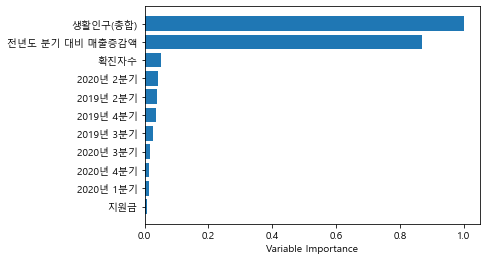

In [65]:
 # coding: utf-8
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

forest = RandomForestRegressor()
forest.fit(train_data, train_data_label)
some_predicted = forest.predict(test_data)
mse = np.sqrt(mean_squared_error(some_predicted, test_data_label))
print('평균제곱근오차', mse)
print("훈련 세트 정확도 : {:.3f}".format(forest.score(train_data,train_data_label)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(test_data,test_data_label)))


# 특성 중요도
# print("특성 중요도 : \n{}".format(forest.feature_importances_))
li = [i for i in zip(forest.feature_importances_,train_data.columns)]
for i in li:
    print(f'{i[1]} : {i[0]}')

#피처 중요도 도표 그리기
featureImportance = forest.feature_importances_

col = np.array(train_data.columns)
#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)

barPos = np.arange(sorted_idx.shape[0])+.5

plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, col[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()


In [57]:
import pandas_profiling
data.profile_report()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 다중선형회귀모델

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(train_data, train_data_label)
some_predicted = model.predict(test_data)
mse = np.sqrt(mean_squared_error(some_predicted, test_data_label))
print('평균제곱근오차', mse)

평균제곱근오차 1.4211701158728551


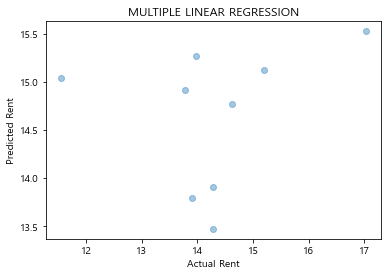

In [82]:
import matplotlib.pyplot as plt
plt.scatter(test_data_label, some_predicted, alpha=0.4)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=4)

X_selected = fs.fit_transform(x.values, y.values)
fs.get_support()

NameError: name 'x' is not defined

In [ ]:
RFS_featurn_2 = [i[1] for i in list(zip(fs.get_support(),x.columns)) if i[0] ]
RFS_featurn_2

In [62]:
import statsmodels.api as sm

In [63]:
x = data.drop(['분기당_매출_금액'],axis=1)
y = data[['분기당_매출_금액']]
model = sm.OLS(y,x)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              분기당_매출_금액   R-squared (uncentered):                   0.984
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                              551.6
Date:                Sun, 18 Jul 2021   Prob (F-statistic):                    1.91e-67
Time:                        16:39:35   Log-Likelihood:                         -180.56
No. Observations:                  88   AIC:                                      379.1
Df Residuals:                      79   BIC:                                      401.4
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
2019년 2분기           1.2280      0.832      1.476      0.144      -0.428       2.884
2019년 3분기           1.0359      0.829      1.249      0.215      -0.615       2.687
2019년 4분기           1.3239      0.829      1.596      0.114      -0.327       2.975
2020년 1분기           1.1363      0.809      1.404      0.164      -0.474       2.747
2020년 2분기           0.3885      0.484      0.803      0.424      -0.574       1.351
2020년 3분기           0.2706      0.459      0.589      0.558      -0.644       1.185
2020년 4분기          -0.1628      0.106     -1.537      0.128      -0.374       0.048
전년도 분기 대비 매출증감액     0.0480      0.013      3.577      0.001       0.021       0.075
생활인구(총합)            1.2649      0.051     24.667      0.000       1.163       1.367
확진자수                0.0064      0.003      2.145      0.035       0.000       0.012
지원금                 0.6591      0.413      1.598      0.114      -0.162       1.480
==============================================================================
Omnibus:                       11.806   Durbin-Watson:                   1.344
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.950
Skew:                           0.742   Prob(JB):                      0.00154
Kurtosis:                       4.153   Cond. No.                     1.02e+20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 9.93e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""